In [1]:
REDUCTION = 'MONTGOMERY' ##### 'MONTGOMERY' or 'PLANTARD'
THS_ID = 0
NSHARES = 3              ##### number of shares in masking scheme (1 for unprotected)
TARGET = 'high'          ##### 'low', 'high', 'lowhigh'
MODEL_STR = 'sin'        #### 'packed', 'signed_hw', 'abs', 'opf', 'sin', 'cos'

In [2]:
N_STEP = 200             ##### Convergence Step
BATCH_SIZE = 50          ##### Batch size for trace processing
N = 10000                ##### Number of Traces
FRAME_STEP = None        ##### Step size for frame of power samples. None for all at once

In [3]:
import sys
sys.path.append('../../../../scaredcu/scaredcu')

In [4]:
import scaredcu
import os
import cupy as cp
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
%matplotlib widget

/home/userfoobar/toluntosun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/userfoobar/toluntosun/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [5]:
cp.cuda.runtime.setDevice(0)

In [6]:
ths = scaredcu.estraces.ets_format.read_ths_from_ets_file(f'traces/kyber_basemult_{REDUCTION.lower()}_d{NSHARES}_t{THS_ID}.ets')

In [7]:
import warnings
warnings.filterwarnings("ignore")

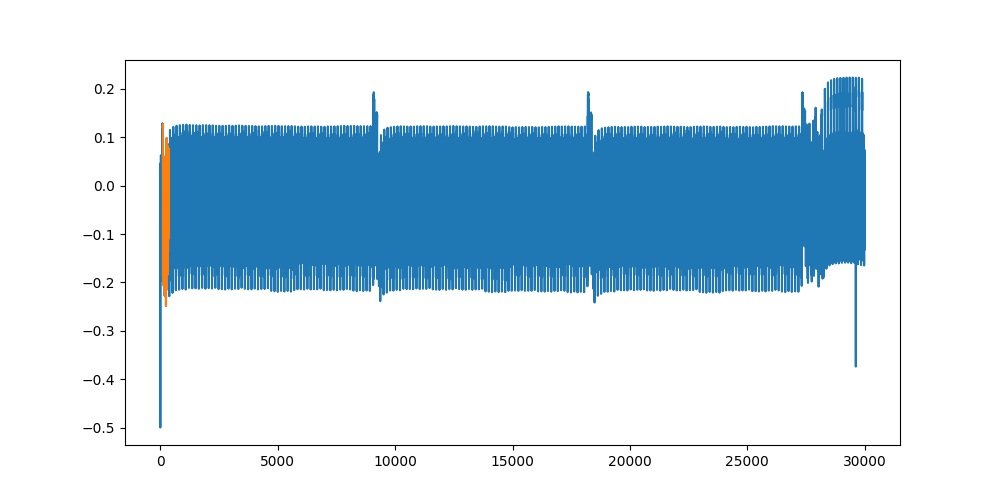

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

mean = ths.samples.mean(axis=0).get()
ref_pattern_range = range(110, 350)
ref_pattern = mean[ref_pattern_range]
ax.plot(mean)
ax.plot(ref_pattern_range, ref_pattern)


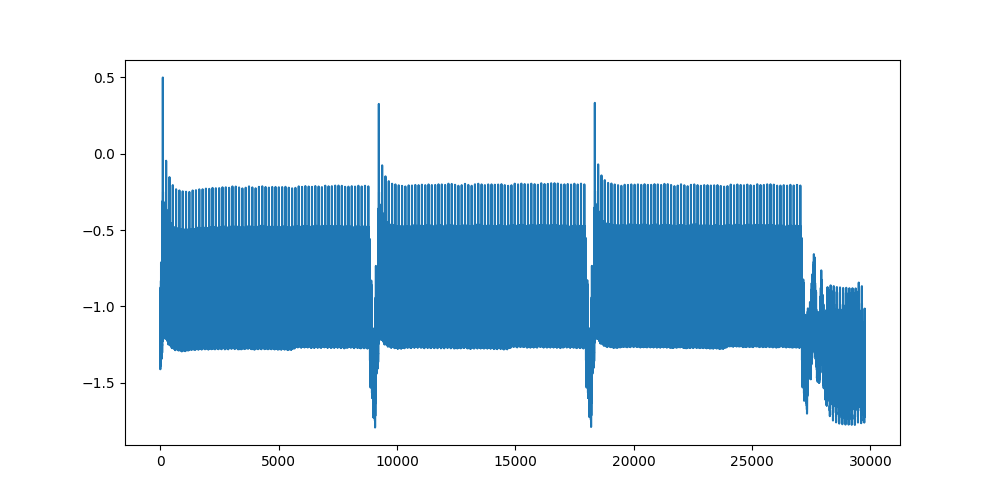

In [9]:
dist = scaredcu.signal_processing.pattern_detection.distance(mean, ref_pattern)

T = 0.5

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
dist_pp = -(dist - T)
ax.plot(dist_pp)

[  110  9234 18358]


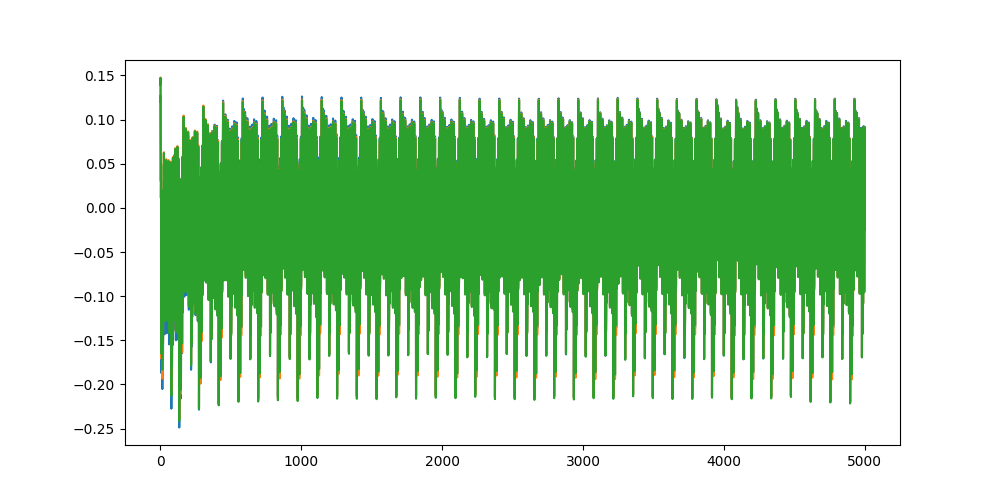

In [10]:
peaks = scaredcu.signal_processing.peaks_detection.find_peaks(dist_pp, 0, 0)

print(peaks)

assert len(peaks) == NSHARES

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for i in range(len(peaks)):
    ax.plot(mean[peaks[i]: peaks[i]+5000])


In [8]:
def make_frame_share(key_index, share, offset=0, length=None):
    if REDUCTION == 'MONTGOMERY':
        # copy below numbers from the output of peak detection
        if NSHARES <= 2:
            R = [93, 9189]
        elif NSHARES == 3:
            R = [110, 9234, 18358]
        K = 140

    elif REDUCTION == 'PLANTARD':
        R = [128, 9740]
        K = 148
    r = range(R[share] + K*(key_index//2), R[share] + K*(key_index//2) + K)
    if length is None:
        return r[offset:]
    else:
        return r[offset:offset+length]

def make_frame(key_index, offset=0, length=None):
    ranges = [make_frame_share(key_index, share, offset, length) for share in range(NSHARES)]
    return sorted(set().union(*ranges))

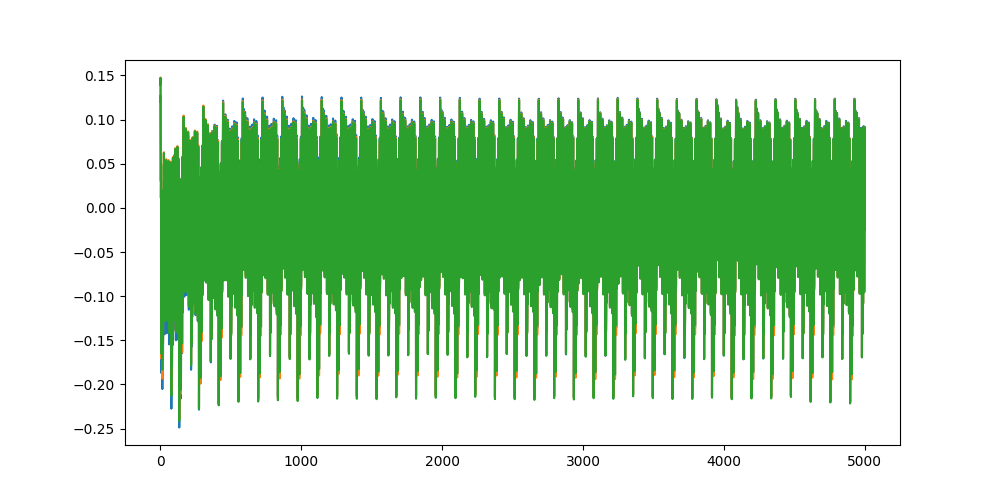

In [12]:
# below plot must be well aligned

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

mean = ths.samples.mean(axis=0).get()

for i in range(3):
    ax.plot(mean[make_frame_share(0, i)[0] : make_frame_share(0, i)[0] + 5000])


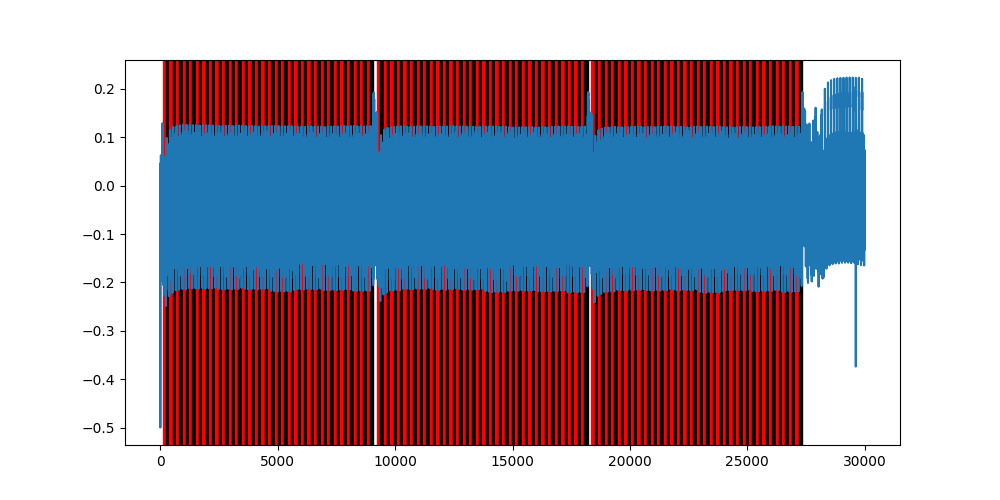

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(mean)

for share in range(NSHARES):
    for ki in range(64):
        frame = make_frame_share(ki*2, share)
        if ki % 2 == 0:
            ax.axvspan(frame[0], frame[-1], color='red')
        else:
            ax.axvspan(frame[0], frame[-1], color='black')


In [9]:
def make_attack_selection(key_index, neg_trick=False):
    if REDUCTION == 'MONTGOMERY':
        reduction = scaredcu.lbc.modop.Reduction_Q2Q2(q=3329,o_dtype='int16') if NSHARES >= 2 and MODEL_STR == 'abs' else None
        # for Montgomery, we perform output correction through above reduction object
        if TARGET == 'high':
            return scaredcu.lbc.kyber.selection_functions.BaseMulMonty(low=False, high=True, words=cp.array([key_index]), neg_trick=neg_trick, reduction=reduction)
        elif TARGET == 'low':
            return scaredcu.lbc.kyber.selection_functions.BaseMulMonty(low=True, high=False, words=cp.array([key_index]), neg_trick=neg_trick, reduction=reduction)
        elif TARGET == 'lowhigh':
            return scaredcu.lbc.kyber.selection_functions.BaseMulMonty(low=True, high=True, words=cp.array([key_index]), neg_trick=neg_trick, reduction=reduction)
    elif REDUCTION == 'PLANTARD':
        if TARGET == 'high':
            return scaredcu.lbc.kyber.selection_functions.BaseMulPlant(low=False, high=True, words=cp.array([key_index]), neg_trick=neg_trick)
        elif TARGET == 'low':
            return scaredcu.lbc.kyber.selection_functions.BaseMulPlant(low=True, high=False, words=cp.array([key_index]), neg_trick=neg_trick)
        elif TARGET == 'lowhigh':
            return scaredcu.lbc.kyber.selection_functions.BaseMulPlant(low=True, high=True, words=cp.array([key_index]), neg_trick=neg_trick)

In [10]:
if MODEL_STR == 'packed':
    model = scaredcu.models.PackedHammingWeight(expected_dtype='uint16')
elif MODEL_STR == 'signed_hw':
    model = scaredcu.models.SignedHammingWeight(expected_dtype='int16')
elif MODEL_STR == 'abs':
    model = scaredcu.models.AbsoluteValue()
elif MODEL_STR == 'opf':
    model = scaredcu.lbc.OPFTableReduction(scaredcu.lbc.modop.Reduction_Q2Q2(q=3329, dtype='int16'),
                                           fix0=False, d=NSHARES)
elif MODEL_STR == 'sin':
    model = scaredcu.models.Sin(q=3329)
elif MODEL_STR == 'cos':
    model = scaredcu.models.Cos(q=3329)

In [11]:
def filename():
    return f'cpa_results_poi/basemult_{REDUCTION.lower()}_d{NSHARES}_t{str(THS_ID)}_{MODEL_STR}_{TARGET}'

if not os.path.isdir(filename()):
    os.mkdir(filename())

In [12]:
scaredcu.models._HW_LUT = cp.array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7,
                     3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5, 5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8], dtype='uint32')

In [13]:
scaredcu.set_batch_size(BATCH_SIZE)

In [14]:
def attack_key_index(key_index, frame_step=FRAME_STEP):
    q = 3329
    frame_length = make_frame_share(0, 0)[-1] - make_frame_share(0, 0)[0] + 1
    results_max = None
    frame_step = frame_step if frame_step is not None else frame_length
    for F in tqdm(range(0, frame_length, frame_step), desc=f'Frame loop key index: {key_index}'):
        frame = make_frame(key_index, offset=F, length=frame_step)
        temp = make_frame_share(key_index, 0, offset=F, length=frame_step)
        distance = temp[-1] - temp[0] + 1
        if NSHARES > 1:
            mean = ths.samples[:N,frame].mean(axis=0)
        cpa = scaredcu.CPAAttackAlternative(selection_function=make_attack_selection(key_index, neg_trick=True),
                                            model=model,
                                            discriminant=scaredcu.maxabs)
            
        for i in tqdm(range(0, N, N_STEP), desc=f'Trace loop key index: {key_index}'):
            Ni = i + N_STEP
            if NSHARES > 1:
                frames = [range(j*distance, (j+1)*distance) for j in range(NSHARES)]
                pp = [scaredcu.preprocesses.high_order.CenteredProductHigh(frames, mean=mean)]
            else:
                pp = []

            container = scaredcu.Container(ths[i:Ni], frame=frame, preprocesses=pp)
            cpa.run(container)
            cpa.results[0,:,:] = 0
            abs_res = cp.abs(cpa.results[:,0,:])
            abs_res_max = abs_res.max(axis=0)
            temp = cp.argmax(abs_res, axis=0)
            # a simple strategy to handle 'some' ghost peaks. eliminate contribution of predictions with null coefficients.
            temp_null = (temp < q) | ((temp % q) == 0) # predictions with at elast one null coeff. satisfy these, see util.unpack_guess
            abs_res_max[temp_null] = cp.min(abs_res_max)

            if results_max is None:
                results_max = cp.empty((N//N_STEP, frame_length), dtype=cp.float32)
            results_max[i//N_STEP, F:F+frame_step] = abs_res_max
        
        del cpa


    for i in range(len(results_max)):
        Ni = (i + 1)*N_STEP
        cp.save(f'{filename()}/ki_{key_index}_{Ni}', results_max[i])

    return results_max


for i in tqdm(range(128)):

    # to avoid memory issues
    del ths
    ths = scaredcu.estraces.ets_format.read_ths_from_ets_file(f'traces/kyber_basemult_{REDUCTION.lower()}_d{NSHARES}_t{THS_ID}.ets')

    results_max = attack_key_index(i)
    if i == 0:
        results_max_even = cp.copy(results_max)
    elif i == 1:
        results_max_odd = cp.copy(results_max)
    elif i % 2 == 0:
        results_max_even += cp.log(results_max)
    else:
        results_max_odd += cp.log(results_max)


  0%|          | 0/128 [00:00<?, ?it/s]

Frame loop key index: 0:   0%|          | 0/1 [00:00<?, ?it/s]

Trace loop key index: 0:   0%|          | 0/50 [00:00<?, ?it/s]

Frame loop key index: 1:   0%|          | 0/1 [00:00<?, ?it/s]

Trace loop key index: 1:   0%|          | 0/50 [00:00<?, ?it/s]

Frame loop key index: 2:   0%|          | 0/1 [00:00<?, ?it/s]

Trace loop key index: 2:   0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
cp.save(f'{filename()}/PoI_even', results_max_even)
cp.save(f'{filename()}/PoI_odd', results_max_odd)

/home/userfoobar/toluntosun/.local/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


NameError: name 'results_max_odd' is not defined

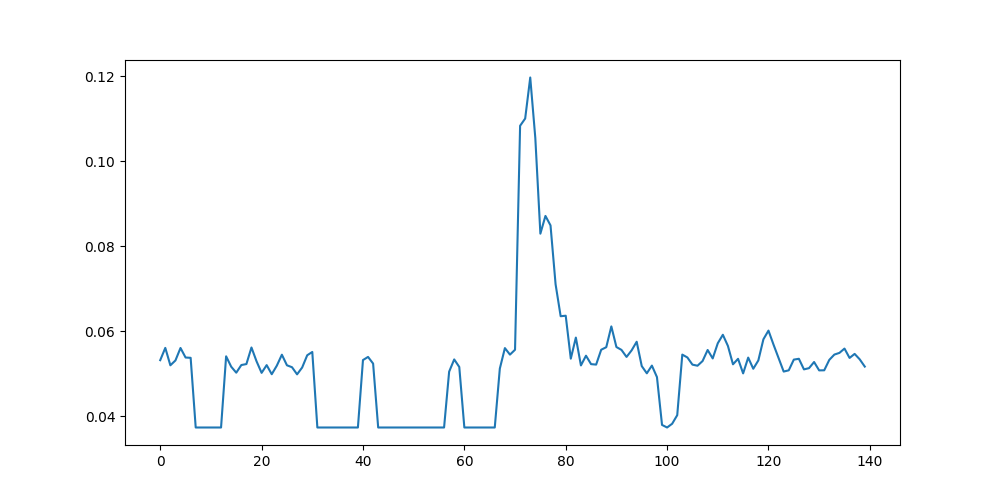

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(results_max_even[-1].get(), label='even')
ax.plot(results_max_odd[-1].get(), label='odd')

ax.legend()